In [1]:
import pandas as pd
import numpy as np 
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import joblib
from xgboost import XGBClassifier

In [2]:
def model_result(clf,y,X,cutoff=0.5):
    """Print Confusion Matrix, ROC_AUC, Lift and etc.
    Parameters
    ----------
    clf : Classifier
        Model
    y : DataFrame/np Array
    X : DataFrame/np Array
    cutoff : double or 'best'. Default = 0.5
        If 'best', find cutoff/threshold where true positive rate is high and the false positive rate is low. 
    Returns
    -------
    None
    """
    from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve
    
    y_score = clf.predict_proba(X)[:,1]
    
    if str(cutoff) == 'best':
        fpr, tpr, threshold = roc_curve(y, y_score)
        i = np.arange(len(tpr)) 
        roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
        roc_t = roc.loc[(roc.tf-0).abs().argsort()[:5]]
        cutoff = list(roc_t['threshold'])[0] 
        print("top5 cutoff: ", list(roc_t['threshold']))
        
    # tn,fp,fn,tp= confusion_matrix(y,clf.predict(X)).flatten() #[1 if i>= cutoff else 0 for i in y_score]
    tn,fp,fn,tp= confusion_matrix(y,np.where(y_score>=cutoff,1,0)).flatten()
    print(clf.__class__)
    print()
    print("n={:^7}   |     cutoff={:.5f}".format(tp+tn+fp+fn,cutoff))
    print("            |     Prediction")
    print("____________|____0__________1___       ")
    print("            |   TN     |    FP                TNR/Spec\t\t"+ "Ratio of FP/TP = {:.2f}".format(fp/tp))
    print("        0   | {:^7}  | {:^7}    {:^7}   {:^7}%\t\t".format(tn, fp, tn+fp,round(tn/(tn+fp)*100, 2))+"Prevalence = {:.2f}%".format((fn+tp)/(fn+tp+fp+tn)*100))
    print("Actual      |__________|_________      \t\t\t\t"+"Accuracy = {:.2f}%".format((tn+tp)/(tn+tp+fn+fp)*100))
    print("            |   FN     |    TP                TPR/Sen/Recall\t"+"ROC AUC Score = {:.2f}".format(roc_auc_score(y,y_score)))
    print("        1   | {:^7}  | {:^7}   {:^7}   {:^7}%\t\t".format(fn, tp, fn+tp,round(tp/(tp+fn)*100,2))+"Lift = %.2f" % (tp/(tp+fp)/(tp+fn)*(tp+tn+fp+fn)))
    print("            |          |               ")
    print("              {:^7}   {:^7}          ".format(tn+fn, fp+tp))
    print()
    print("                NPV       PPV,Preci")
    print("              {:^7}%   {:^7}%".format(round(tn/(tn+fn)*100,2),round(tp/(tp+fp)*100,2)))


In [3]:
pd.set_option('display.max_columns', None) #inv_churn

In [4]:
# df = pd.read_csv('data.csv')
df = pd.read_csv('data2.csv')
df.head()
df_backup = df.copy()

In [5]:
y1='dormant14'
y2='dormant30'

y=y2

In [6]:
df[y].value_counts()

0    8228815
1      30954
Name: dormant30, dtype: int64

In [7]:
df.shape

(8259769, 37)

In [8]:
df1=df
df1.shape

(8259769, 37)

In [9]:
## Undersample randomly
Zeros = df1.loc[df1[y]==0].sample(frac = 0.1, random_state=323)
Ones = df1.loc[df1[y]==1]
df_final = pd.concat([Zeros, Ones])

In [10]:
df_final.shape

(853836, 37)

In [11]:
final_col = [
    'status_active',
    'device_type_basic_phone',
    'device_type_feature_phone',
    'main_account_balance',
    'months_in_status',
    'data_vol_gb',
    'num_out_call',
    'amt_reload_60',
    'num_reload_30',
    'reload_validity', 
    'mi_monthly',
    'monetz_target',
    'reten_target',
    'loyal_target',
    'nonclm_target',
    'dormant_target',
    'dormant_taker',
    'reload_rfm',
    'a',
    'b',
    'dormant30'
]

In [12]:
for i in final_col:
    print(i)

status_active
device_type_basic_phone
device_type_feature_phone
main_account_balance
months_in_status
data_vol_gb
num_out_call
amt_reload_60
num_reload_30
reload_validity
mi_monthly
monetz_target
reten_target
loyal_target
nonclm_target
dormant_target
dormant_taker
reload_rfm
a
b
dormant30


In [13]:
df_final = df_final.loc[:,final_col]

In [14]:
df_final.shape

(853836, 21)

In [15]:
for i in df_final.columns:
    print(i)

status_active
device_type_basic_phone
device_type_feature_phone
main_account_balance
months_in_status
data_vol_gb
num_out_call
amt_reload_60
num_reload_30
reload_validity
mi_monthly
monetz_target
reten_target
loyal_target
nonclm_target
dormant_target
dormant_taker
reload_rfm
a
b
dormant30


# Train Test Split

In [16]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_final, test_size = .15 ,random_state = 322, stratify=df_final[y])
train, validation = train_test_split(train, test_size = .1, random_state = 435,stratify=train[y])

In [17]:
x_train = train.iloc[:,:-1]
y_train = train[[y]]
x_eval = validation.iloc[:,:-1]
y_eval = validation[[y]]
x_test = test.iloc[:,:-1]
y_test = test[[y]]

# Model Building

In [18]:
y_train[y].value_counts()

0    629504
1     23680
Name: dormant30, dtype: int64

In [19]:
629504/23680 #y2

26.583783783783783

In [20]:
sample_weight = [26 if i==1 else 1 for i in y_train[y]]

In [21]:
x_train.shape

(653184, 20)

In [22]:
eval_set =[(x_eval, y_eval)]
clf = XGBClassifier(n_jobs=-1,
                    learning_rate=0.05,
                    max_depth=3,
                    min_child_weight=4,
                    subsample=0.8)

clf_x = clf.fit(x_train, y_train,
                eval_metric='auc',
                sample_weight=sample_weight,
                verbose=True,
                early_stopping_rounds=10,
                eval_set=eval_set)

model_result(clf_x, y_train, x_train, cutoff=0.5)

[0]	validation_0-auc:0.87144
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.87709
[2]	validation_0-auc:0.89544
[3]	validation_0-auc:0.89528
[4]	validation_0-auc:0.89532
[5]	validation_0-auc:0.89556
[6]	validation_0-auc:0.89630
[7]	validation_0-auc:0.89632
[8]	validation_0-auc:0.89775
[9]	validation_0-auc:0.89791
[10]	validation_0-auc:0.89838
[11]	validation_0-auc:0.89884
[12]	validation_0-auc:0.89888
[13]	validation_0-auc:0.89951
[14]	validation_0-auc:0.89940
[15]	validation_0-auc:0.89970
[16]	validation_0-auc:0.90004
[17]	validation_0-auc:0.90025
[18]	validation_0-auc:0.90046
[19]	validation_0-auc:0.90062
[20]	validation_0-auc:0.90248
[21]	validation_0-auc:0.90291
[22]	validation_0-auc:0.90316
[23]	validation_0-auc:0.90331
[24]	validation_0-auc:0.90352
[25]	validation_0-auc:0.90406
[26]	validation_0-auc:0.90457
[27]	validation_0-auc:0.90495
[28]	validation_0-auc:0.90522
[29]	validation_0-auc:0.90546
[30]	validation_0-auc:0.90594
[31]	validation_

In [23]:
model_result(clf_x,y_test,x_test, cutoff=0.5)

<class 'xgboost.sklearn.XGBClassifier'>

n=128076    |     cutoff=0.50000
            |     Prediction
____________|____0__________1___       
            |   TN     |    FP                TNR/Spec		Ratio of FP/TP = 3.84
        0   | 109052   |  14381     123433     88.35 %		Prevalence = 3.63%
Actual      |__________|_________      				Accuracy = 88.07%
            |   FN     |    TP                TPR/Sen/Recall	ROC AUC Score = 0.92
        1   |   898    |  3745      4643      80.66 %		Lift = 5.70
            |          |               
              109950     18126           

                NPV       PPV,Preci
               99.18 %    20.66 %


# OOTV

In [24]:
df_ootv = pd.read_csv('ootv_data2.csv')
df_ootv.head()
df_ootv_backup = df_ootv.copy()

In [35]:
x_ootv1, y_ootv1 = ootv1.iloc[:,:-1], ootv1.loc[:,y]
x_ootv2, y_ootv2 = ootv2.iloc[:,:-1], ootv2.loc[:,y]
x_ootv3, y_ootv3 = ootv3.iloc[:,:-1], ootv3.loc[:,y]

In [37]:
model_result(clf_x, y_ootv1, x_ootv1, cutoff=0.935)

<class 'xgboost.sklearn.XGBClassifier'>

n=2782480   |     cutoff=0.93500
            |     Prediction
____________|____0__________1___       
            |   TN     |    FP                TNR/Spec		Ratio of FP/TP = 5.99
        0   | 2751188  |  21309     2772497    99.23 %		Prevalence = 0.36%
Actual      |__________|_________      				Accuracy = 99.00%
            |   FN     |    TP                TPR/Sen/Recall	ROC AUC Score = 0.92
        1   |  6424    |  3559      9983      35.65 %		Lift = 39.89
            |          |               
              2757612    24868           

                NPV       PPV,Preci
               99.77 %    14.31 %


In [38]:
model_result(clf_x, y_ootv2, x_ootv2, cutoff=0.935)

<class 'xgboost.sklearn.XGBClassifier'>

n=2856499   |     cutoff=0.93500
            |     Prediction
____________|____0__________1___       
            |   TN     |    FP                TNR/Spec		Ratio of FP/TP = 6.03
        0   | 2820190  |  24084     2844274    99.15 %		Prevalence = 0.43%
Actual      |__________|_________      				Accuracy = 98.87%
            |   FN     |    TP                TPR/Sen/Recall	ROC AUC Score = 0.92
        1   |  8228    |  3997      12225     32.7  %		Lift = 33.26
            |          |               
              2828418    28081           

                NPV       PPV,Preci
               99.71 %    14.23 %


In [39]:
model_result(clf_x, y_ootv3, x_ootv3, cutoff=0.935)

<class 'xgboost.sklearn.XGBClassifier'>

n=2806558   |     cutoff=0.93500
            |     Prediction
____________|____0__________1___       
            |   TN     |    FP                TNR/Spec		Ratio of FP/TP = 5.91
        0   | 2775170  |  21278     2796448    99.24 %		Prevalence = 0.36%
Actual      |__________|_________      				Accuracy = 99.01%
            |   FN     |    TP                TPR/Sen/Recall	ROC AUC Score = 0.92
        1   |  6509    |  3601      10110     35.62 %		Lift = 40.18
            |          |               
              2781679    24879           

                NPV       PPV,Preci
               99.77 %    14.47 %


## Permutation Importance ##

In [40]:
import eli5
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(clf_x).fit(x_train, y_train)
eli5.show_weights(perm,feature_names =x_train.columns.tolist(), top = None)

Using TensorFlow backend.


Weight,Feature
0.0079 ± 0.0002,num_out_call
0.0064 ± 0.0003,main_account_balance
0.0025 ± 0.0001,b
0.0013 ± 0.0003,reload_validity
0.0002 ± 0.0001,data_vol_gb
0.0000 ± 0.0000,device_type_basic_phone
0.0000 ± 0.0000,device_type_feature_phone
0 ± 0.0000,dormant_target
0 ± 0.0000,nonclm_target
0 ± 0.0000,loyal_target


Text(0.5, 0, 'Relative Importance')

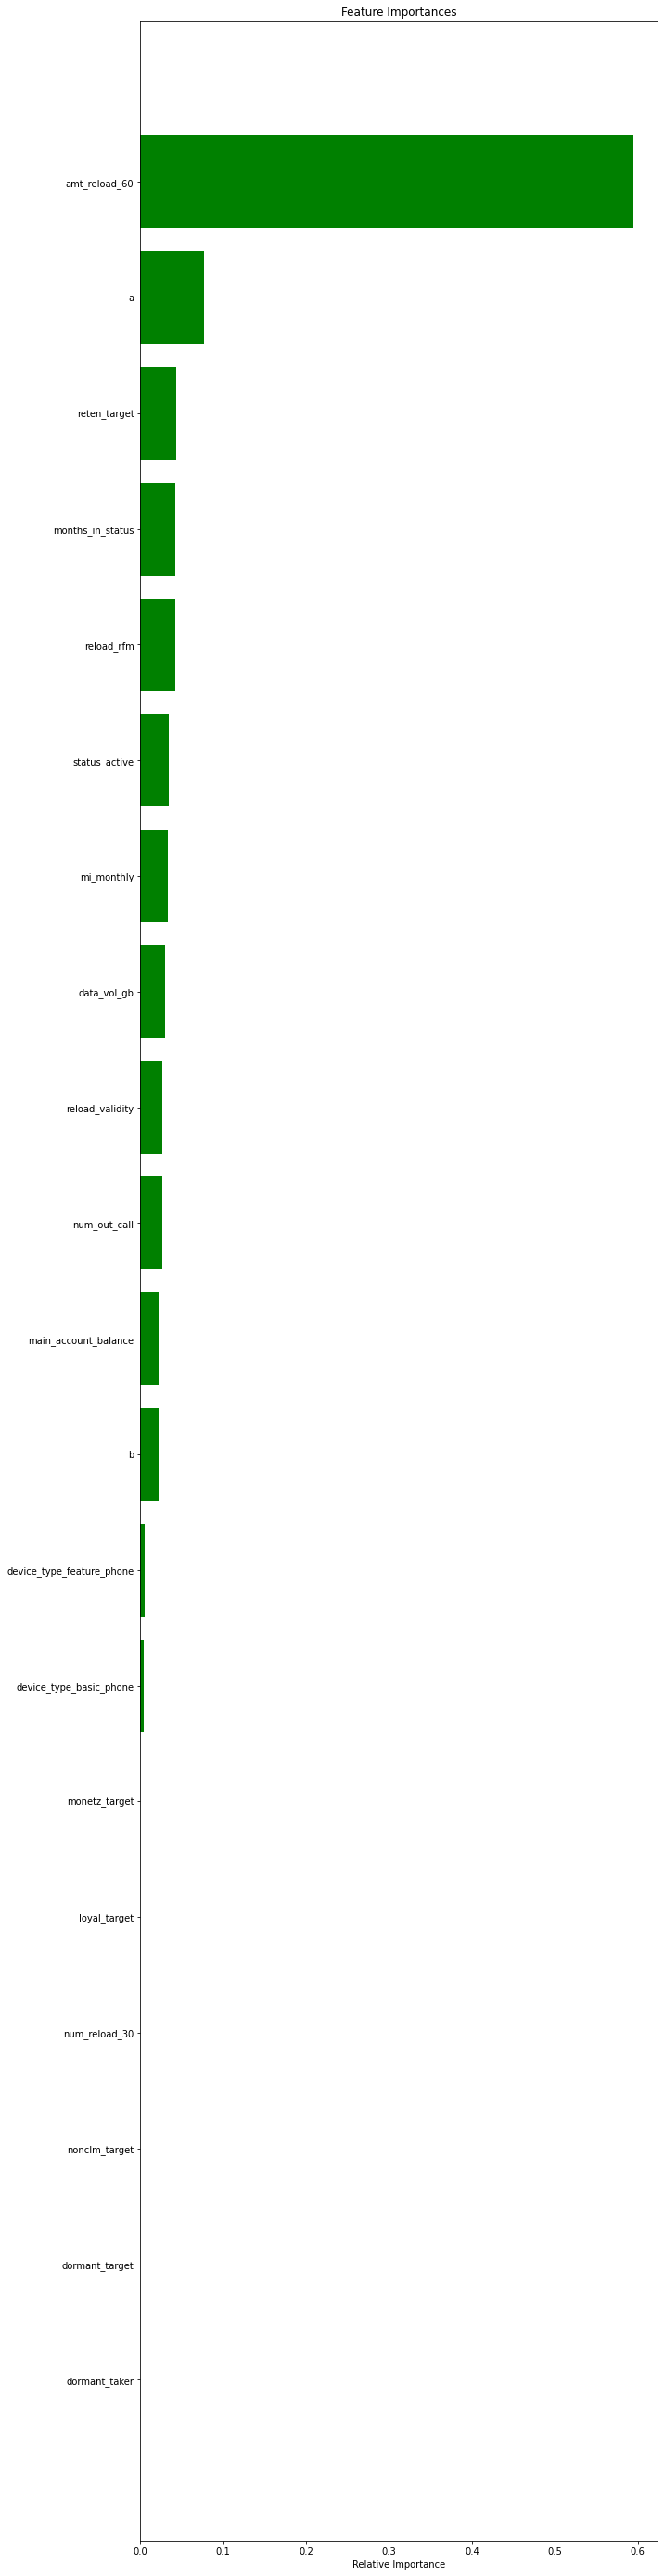

In [41]:
importances = clf_x.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10,50))
features=x_train.columns
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')